Imports

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

%matplotlib inline

Matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
import pywt

def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [4]:
data_path  = "/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/"
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()






In [5]:
records = list()
annotations = list()

for file in os.listdir(data_path):
    if file.endswith(".csv"):
        records.append(data_path+file)
    elif file.endswith(".txt"):
        annotations.append(data_path+file)

In [6]:
records.sort()
annotations.sort()

In [7]:
records[0:5], annotations[0:5]

(['/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/100.csv',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/101.csv',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/102.csv',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/103.csv',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/104.csv'],
 ['/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/100annotations.txt',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/101annotations.txt',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/102annotations.txt',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/103annotations.txt',
  '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/104annotations.txt'])

Data Extraction and Preprocessing

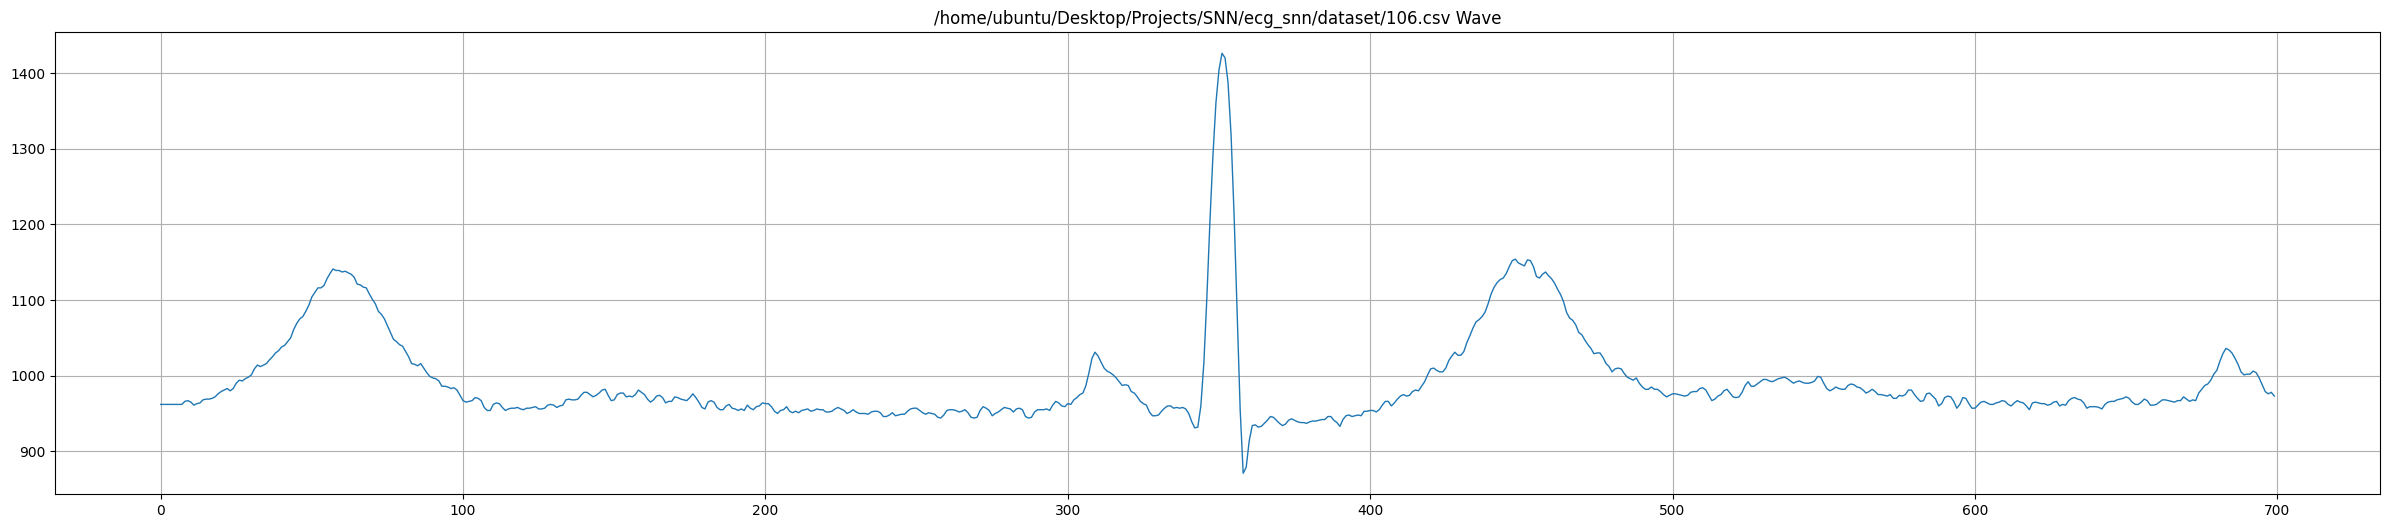

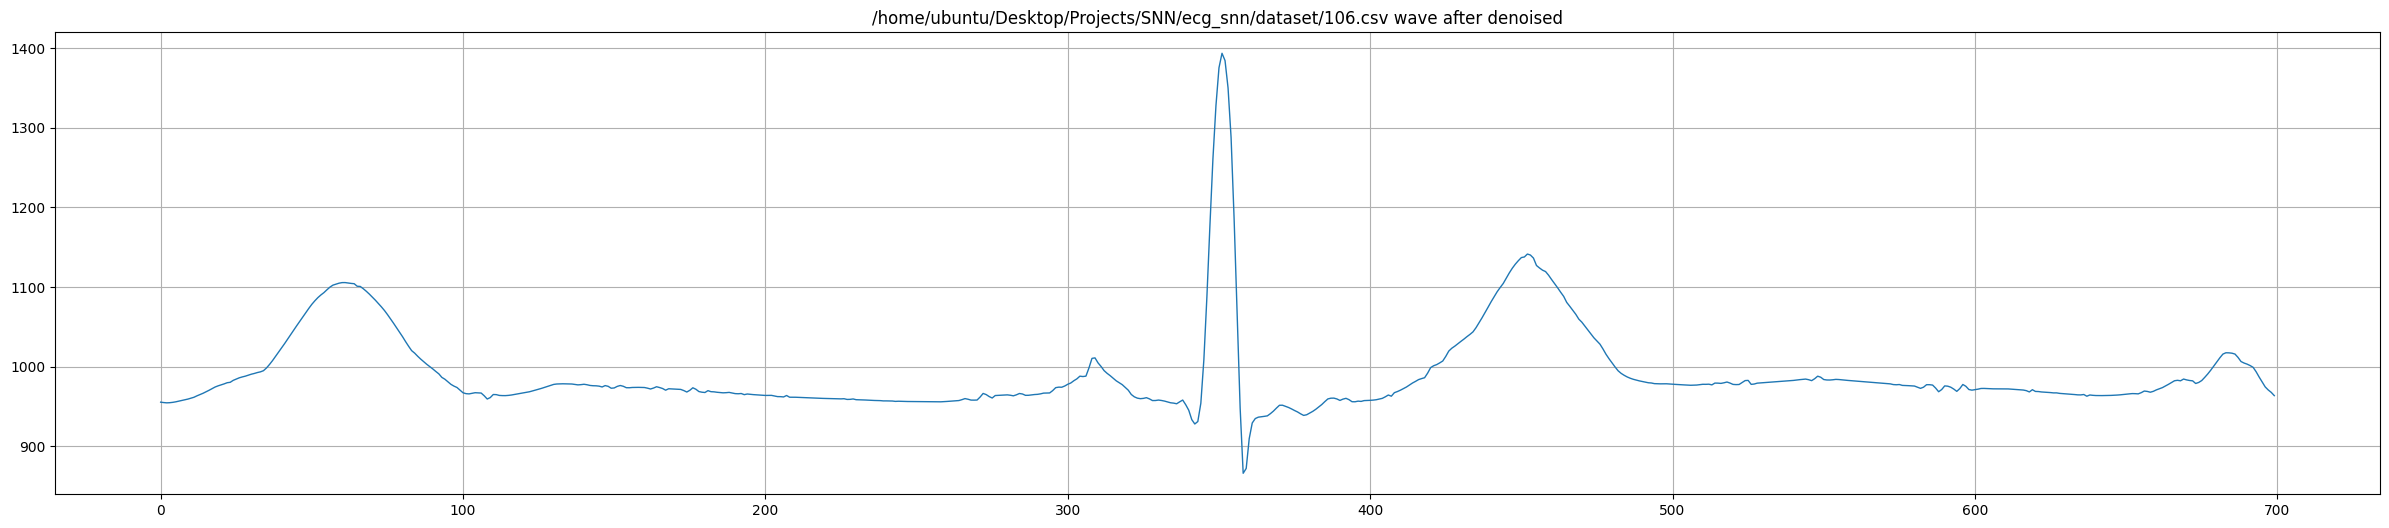

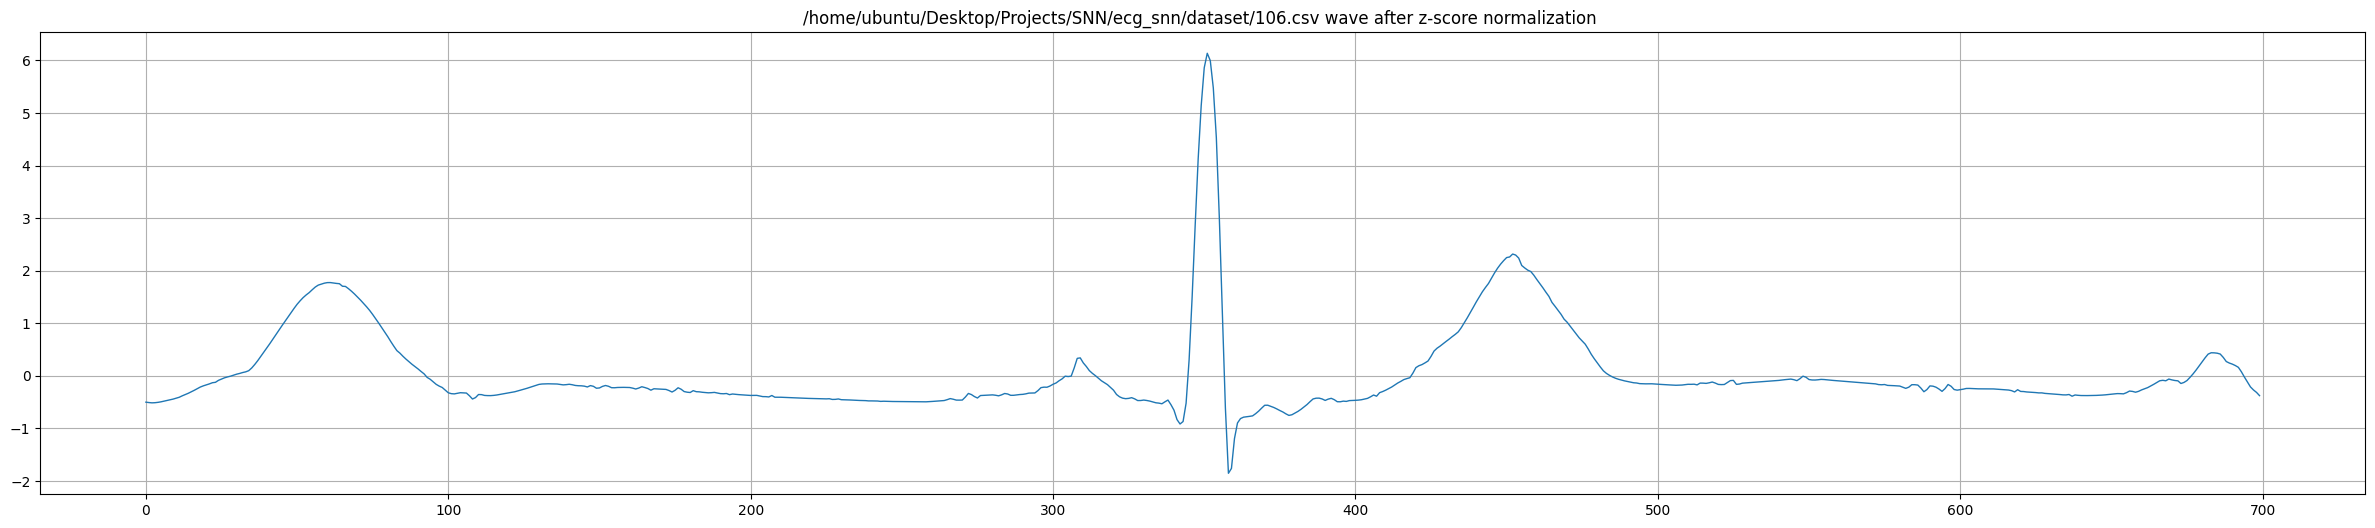

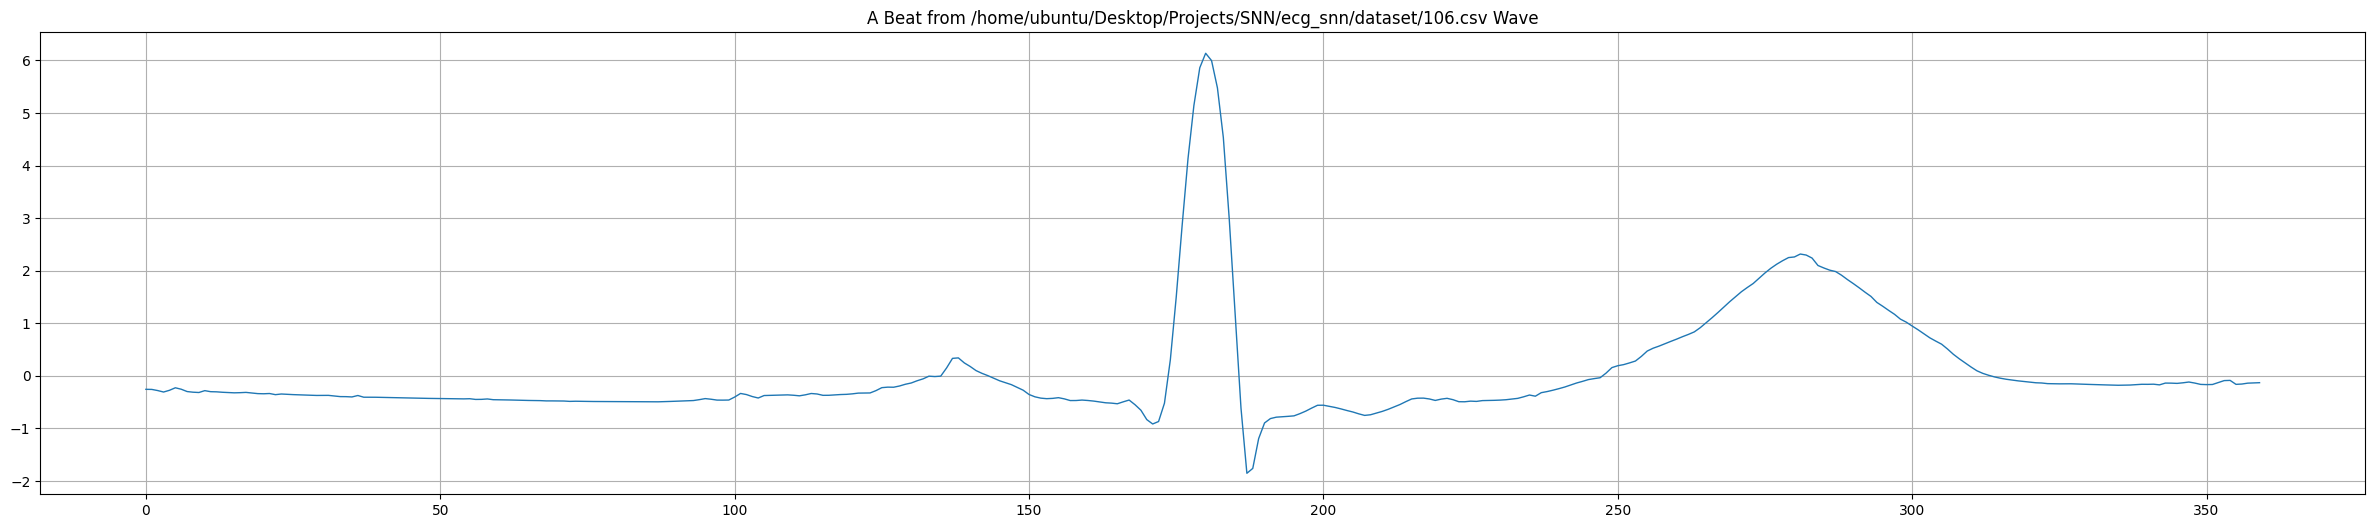

(100012, 360) (100012,)


In [8]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

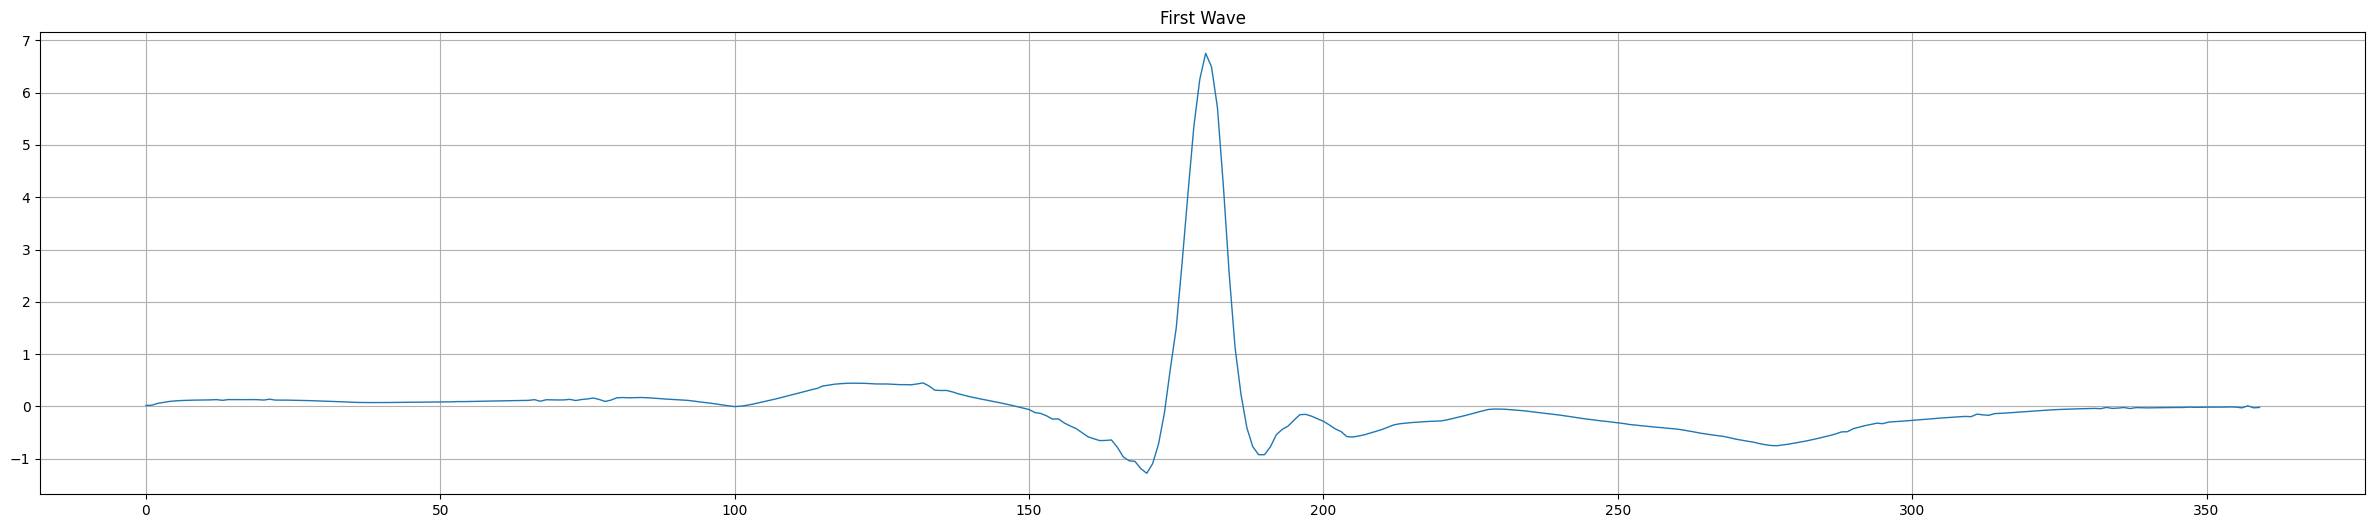

In [9]:
plt.title('First Wave')
plt.plot(X[0])
plt.show()



In [10]:
len(X)

100012

In [11]:
from collections import Counter



class_counts = Counter(y)

for class_label, ch in class_counts.items():
    print(f"Class {class_label}: {ch} occurrences")


Class 0: 75011 occurrences
Class 3: 2546 occurrences
Class 4: 7129 occurrences
Class 1: 8071 occurrences
Class 2: 7255 occurrences


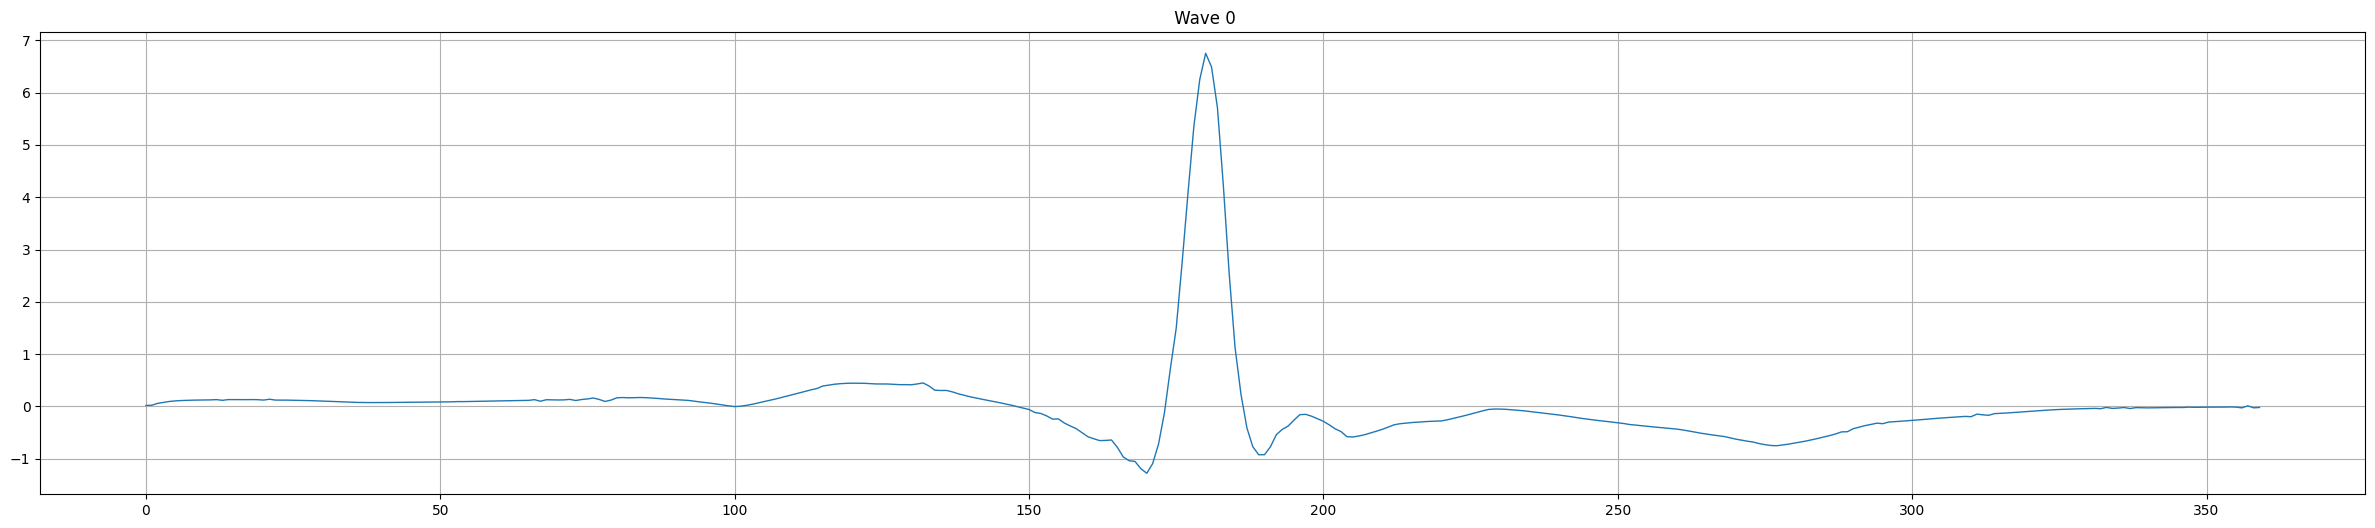

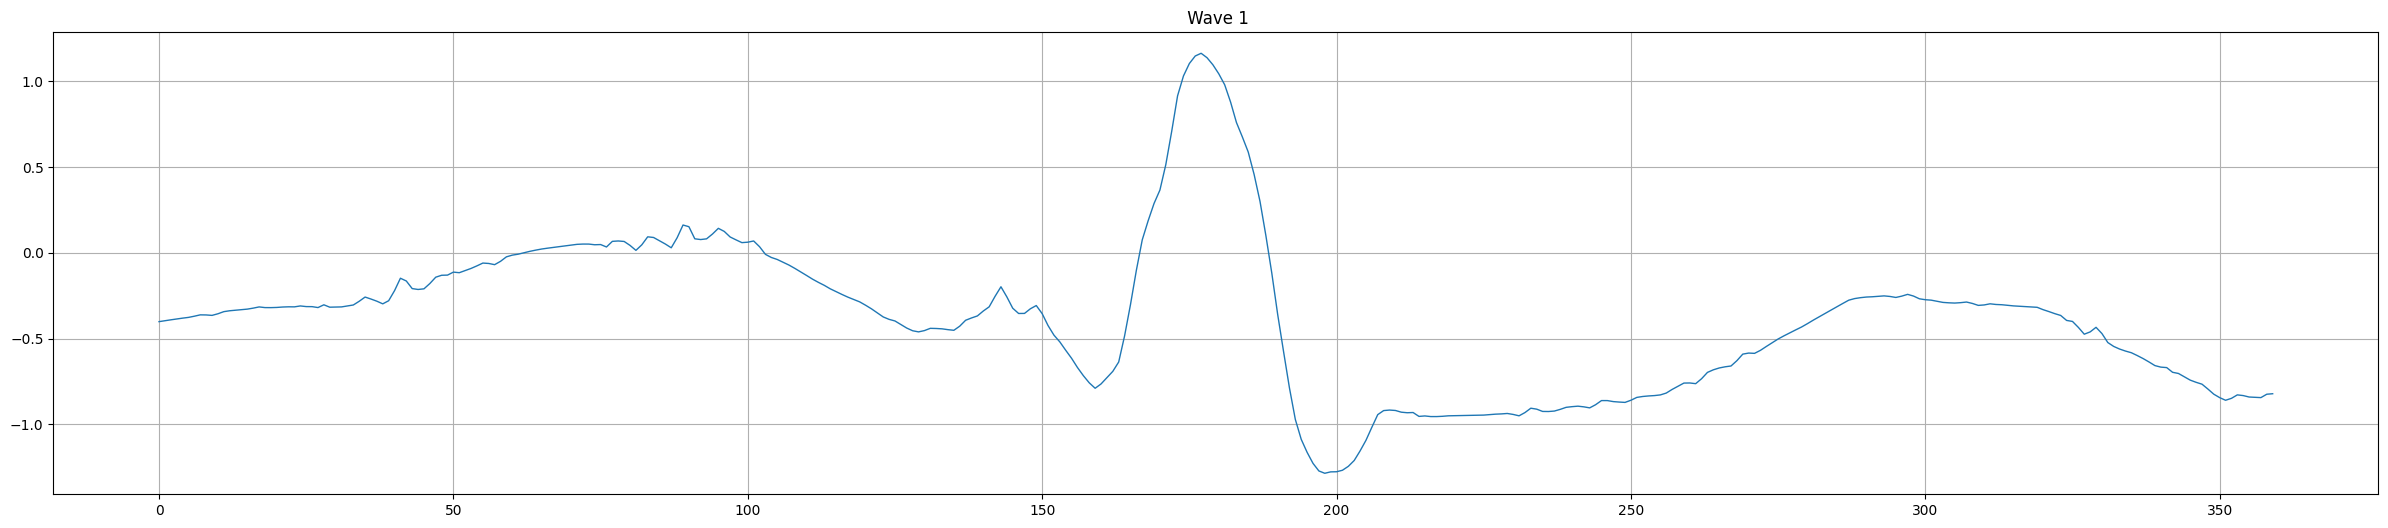

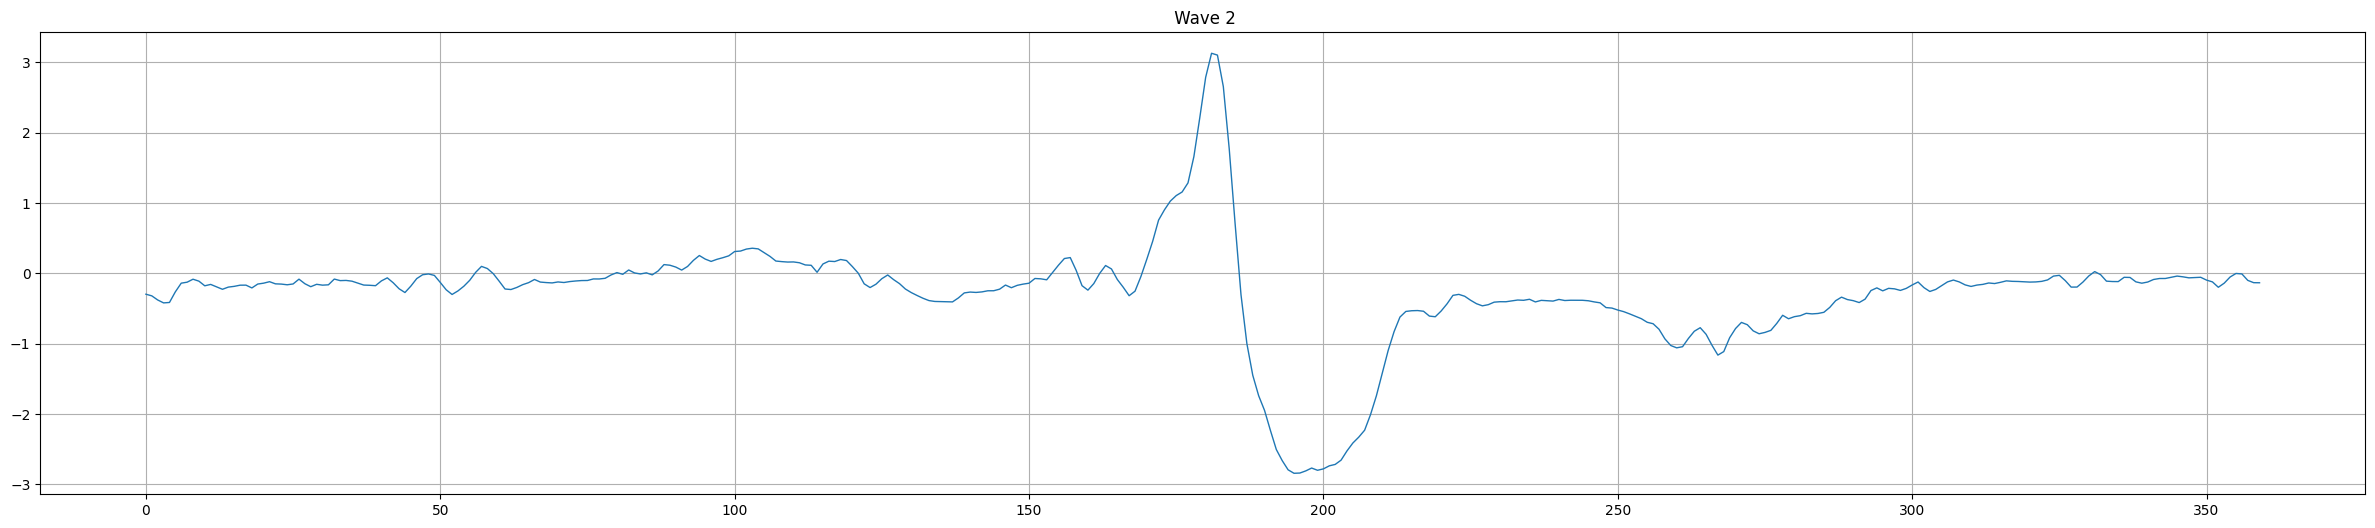

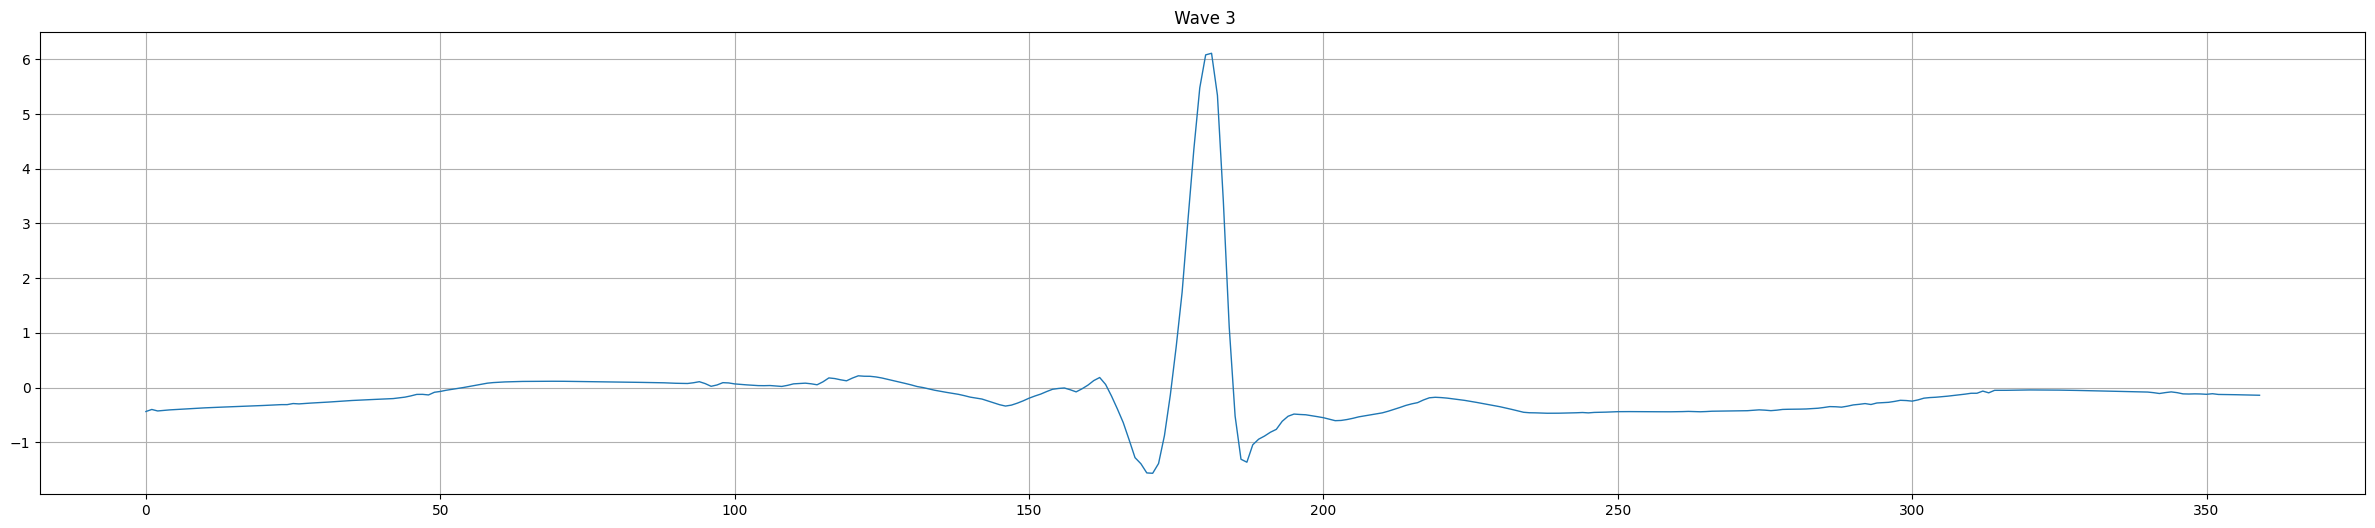

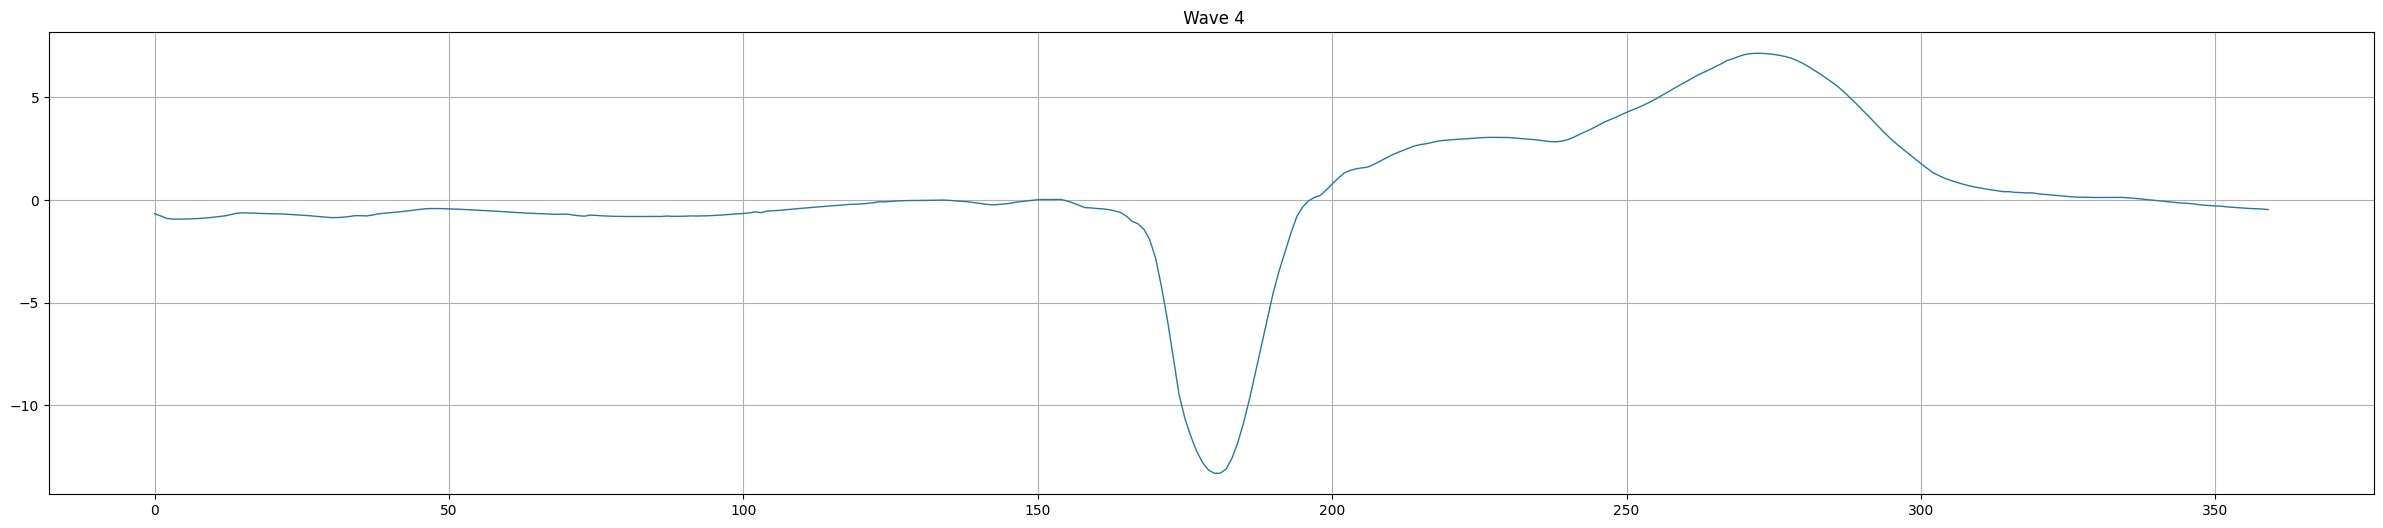

In [14]:


for class_label in range(0,5):
    # Find the first sample in X_train with the current class label
    sample_index = np.argmax(np.array(y) == class_label)

    plt.title(f" Wave {y[sample_index]}")
    plt.plot(X[sample_index])
    plt.show()

In [12]:
# Save the signals in a file

# folder_path = '/home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/signals/'

# data = np.column_stack((X, y))  # Stack X and y side by side
# file_path = os.path.join(folder_path, 'data.txt')
# np.savetxt(file_path, data, delimiter='\t', fmt='%s')

# print(f'Data saved to {file_path}')

Data saved to /home/ubuntu/Desktop/Projects/SNN/ecg_snn/dataset/signals/data.txt
